In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='dark')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
train = pd.read_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\train.csv")
test = pd.read_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\test.csv")
sample_sub = pd.read_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\sample_submission_V9Inaty.csv")

Steps to make baseline Regression Model

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a regression Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

---
### 1. Concating Train and Test Set

In [9]:
df = pd.concat([train, test], axis = 0).reset_index(drop=True)
df.shape

(783667, 12)

---
### 2. Missing Value Imputation

In [10]:
df = df.fillna(-999.0)
df.isnull().sum().sum()

0

### 3. Convert all categorical columns to number

In [11]:
df['Gender'].replace( { 'M' : 1, 'F' : 0}, inplace=True)
df['Age'].replace( {'0-17': 0, '18-25':1, '26-35':2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}, inplace=True)
df['Stay_In_Current_City_Years'].replace( {'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}, inplace=True)

##### Convering User_ID and Product_ID

In [12]:
le = LabelEncoder()
scaler = StandardScaler()
##### User_ID
df['User_ID'] = df['User_ID'] - 1000000
df['User_ID'] = le.fit_transform(df['User_ID'])

##### Product_ID
df['Product_ID'] = df['Product_ID'].str.replace('P00', '')
df['Product_ID'] = le.fit_transform(df['Product_ID'])

##### City Category
df['City_Category'] = le.fit_transform(df['City_Category'])

In [13]:
#dummy_cols = ['Occupation', 'City_Category', 'Product_Category_1', 'Product_Category_2','Product_Category_3']
#df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)

In [14]:
# Changing Datatype

df['User_ID'] = df['User_ID'].astype('int16')
df['Product_ID'] = df['Product_ID'].astype('int16')
df['Gender'] = df['Gender'].astype('uint8')
df['Age'] = df['Age'].astype('uint8')
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].astype('uint8')
df['Marital_Status'] = df['Marital_Status'].astype('uint8')
df['Product_Category_1'] = df['Product_Category_1'].astype('int8')
df['Product_Category_2'] = df['Product_Category_2'].astype('int16')
df['Product_Category_3'] = df['Product_Category_3'].astype('int16')
df['Occupation'] = df['Product_Category_3'].astype('int8')



df['Purchase'] = df["Purchase"].astype('int32')

---
## 4. Split the processed dataset back into train and test datasets

In [15]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)

In [16]:
target = 'Purchase'

features = [col for col in train_proc.columns if col not in [target]]

---
## 5. Split the Train Set into Validation Set

In [17]:
trn, val = train_test_split(train_proc, test_size = 0.2, random_state = 1999)

##### Input for model
X_trn, X_val = trn[features], val[features]

##### Target column
y_trn, y_val = trn[target], val[target]

##### Features for test data that we will be predicting
X_test = test_proc[features]

---
## 6. Fit a Regression Model on train, check its result on validation set

#### 1. Linear Regression

In [18]:
%%time
lr = LinearRegression()

lr.fit(X_trn, y_trn)

preds = lr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, preds))

print(f'RMSE score is: {rmse}')

RMSE score is: 4587.3615494652795
Wall time: 221 ms


In [14]:
test_preds = lr.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Regression_preds.csv", index = False)

#### 2. Decision Tree 

In [19]:
%%time
dt = DecisionTreeRegressor(random_state = 1999, max_depth = 20, max_features = 0.9, max_leaf_nodes = 150)

dt.fit(X_trn, y_trn)

preds = dt.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, preds))

print(f'RMSE score is: {rmse}')

RMSE score is: 2838.627137564156
Wall time: 924 ms


In [15]:
test_preds = dt.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Regression_preds.csv", index = False)

#### 3. Random Forest

In [333]:
%%time
rf = RandomForestRegressor(max_depth = 20, max_features = 0.9, max_leaf_nodes = 150, n_estimators = 300)

rf.fit(X_trn, y_trn)

preds = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, preds))

print(f'RMSE score is: {rmse}')

RMSE score is: 2845.3649194844456
Wall time: 13min 15s


In [17]:
test_preds = model.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Regression_preds.csv", index = False)

---
# Setting Validation Strategy

## Stratified Cross Validation

In [20]:
def cross_val(regressor, train, test, features):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train[target]
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True)
    stratified_target = pd.qcut( train[target], 10, labels = False, duplicates = 'drop')
    
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n=========================Fold{index+1}============================')
        
        ####### Getting Train, Validation and Test sets.
        
        ## Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target_col.iloc[trn_idx]
        
        ## Validation Set
        X_val, y_val = train[features].iloc[val_idx], target_col.iloc[val_idx]
        
        ## Test Set
        X_test = test[features]
        
        ###### Scaling Data ######
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)
        
        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        
        ############ Fitting And Predicting #############
        _ = regressor.fit(X_trn, y_trn)
        
        ## Predicting
        val_preds = regressor.predict(X_val)
        test_preds = regressor.predict(X_test)
        
        fold_score = np.sqrt( mean_squared_error(y_val, val_preds))
        print(f'\n RMSE score for Validation set is : {fold_score}')
        
        oofs[val_idx] = val_preds
        preds += test_preds / N_splits
        
    oofs_score = np.sqrt( mean_squared_error(target_col, oofs))
    print(f'\n\nRMSE score for oofs is {oofs_score}')
    
    return oofs, preds

# Predicting With Cross Validation

### 1. Linear Regression

In [323]:
%%time
lr_oofs, lr_preds = cross_val(lr, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2984.4625149227513

=========================Fold2============================

 RMSE score for Validation set is : 2969.04937780939

=========================Fold3============================

 RMSE score for Validation set is : 2991.5212663954994

=========================Fold4============================

 RMSE score for Validation set is : 2971.9790028093817

=========================Fold5============================

 RMSE score for Validation set is : 2967.118164146688


RMSE score for oofs is 2976.8412916897996
Wall time: 16.7 s


In [211]:
sample_sub['Purchase'] = lr_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Cross_val_preds.csv", index = False)

### 2. Decision Tree

In [308]:
%%time
dt_oofs, dt_preds = cross_val(dt, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2883.6140013696963

=========================Fold2============================

 RMSE score for Validation set is : 2873.212989849003

=========================Fold3============================

 RMSE score for Validation set is : 2879.477351180446

=========================Fold4============================

 RMSE score for Validation set is : 2889.54086908081

=========================Fold5============================

 RMSE score for Validation set is : 2871.8953695104306


RMSE score for oofs is 2879.555581482756
Wall time: 30.4 s


In [90]:
sample_sub['Purchase'] = dt_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Cross_val_preds.csv", index = False)

### 2. Random Forest

In [94]:
rf = RandomForestRegressor(max_depth = 20, max_features = 0.9, max_leaf_nodes = 150, n_estimators = 300, n_jobs = -3)

rf_oofs, rf_preds = cross_val(rf, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2981.1920511557773

=========================Fold2============================

 RMSE score for Validation set is : 2970.444471294864

=========================Fold3============================

 RMSE score for Validation set is : 2978.710606333425

=========================Fold4============================

 RMSE score for Validation set is : 2970.841544926764

=========================Fold5============================

 RMSE score for Validation set is : 3922.5929257758016


RMSE score for oofs is 3187.3613735910976


In [96]:
sample_sub['Purchase'] = rf_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Cross_val_preds.csv", index = False)

---
# Gradient Boosting

### 1. LGBM 

In [21]:
%%time
lgb = LGBMRegressor()
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')



RMSE score is: 2750.9148578630166
Wall time: 1.51 s


In [347]:
test_preds = lgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [17]:
lgb_oofs, lgb_preds = cross_val(lgb, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2759.899923848875

=========================Fold2============================

 RMSE score for Validation set is : 2762.192708711764

=========================Fold3============================

 RMSE score for Validation set is : 2760.918608273542

=========================Fold4============================

 RMSE score for Validation set is : 2753.2533288549744

=========================Fold5============================

 RMSE score for Validation set is : 2760.8781442172553


RMSE score for oofs is 2759.4303748483576


In [349]:
sample_sub['Purchase'] = lgb_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

#### Hyperparameter tuning

In [361]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves,
        colsample_bytree = colsample_bytree,
        min_child_samples=min_child_samples,
        random_state=0,
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMRegressor(**lgb_params)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-04 18:25:41,849] A new study created in memory with name: no-name-821498e1-b01b-4204-aef8-a5969749a25e
[I 2020-10-04 18:25:45,244] Trial 0 finished with value: 2600.2279166615594 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7436704297351775, 'num_leaves': 4933, 'colsample_bytree': 0.7863564940982054, 'min_child_samples': 106, 'reg_alpha': 10, 'reg_lambda': 4}. Best is trial 0 with value: 2600.2279166615594.
[I 2020-10-04 18:26:20,031] Trial 1 finished with value: 2723.1312682528246 and parameters: {'max_depth': 23, 'n_estimators': 243, 'learning_rate': 0.49382849013642327, 'num_leaves': 3470, 'colsample_bytree': 0.40675321506062223, 'min_child_samples': 42, 'reg_alpha': 8, 'reg_lambda': 9}. Best is trial 0 with value: 2600.2279166615594.
[I 2020-10-04 18:26:29,614] Trial 2 finished with value: 2638.8272160665333 and parameters: {'max_depth': 19, 'n_estimators': 166, 'learning_rate': 0.8524708871836397, 'num_leaves': 2165, 'colsample_bytree': 0.394

LGBMRegressor(colsample_bytree=0.7931374592061713,
              learning_rate=0.7256970569232428, max_depth=7,
              min_child_samples=128, n_estimators=399, num_leaves=743,
              random_state=0, reg_alpha=10, reg_lambda=1)

Optimized LightGBM roc_auc_score 2583.5127741180045


In [13]:
%%time
params = {'colsample_bytree' : 0.7, 'max_depth': 18, 'n_estimators': 300, 'learning_rate': 0.2, 'num_leaves': 1779, 'min_child_samples': 181, 'reg_alpha': 3, 'reg_lambda': 1}
lgb = LGBMRegressor(**params)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

RMSE score is: 2541.370069699907
Wall time: 17.6 s


In [376]:
test_preds = lgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [ ]:
lgb_oofs, lgb_preds = cross_val(lgb, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2540.2632988342307

=========================Fold2============================

 RMSE score for Validation set is : 2539.1805123691934

=========================Fold3============================


In [378]:
sample_sub['Purchase'] = lgb_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

---
### 2. XGBoost Regressor

In [ ]:
%%time
#xgb = XGBRegressor(learning_rate=1.0, max_depth=6, min_child_weight=40, seed=0)
xgb = XGBRegressor()
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

In [355]:
test_preds = xgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [35]:
xgb_oofs, xgb_preds = cross_val(xgb, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2675.8850048480826

=========================Fold2============================

 RMSE score for Validation set is : 2675.5238106692345

=========================Fold3============================

 RMSE score for Validation set is : 2682.053393146545

=========================Fold4============================

 RMSE score for Validation set is : 2677.727826130279

=========================Fold5============================

 RMSE score for Validation set is : 2686.2986273776137


RMSE score for oofs is 2679.500886560412


In [357]:
sample_sub['Purchase'] = xgb_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

#### Hyperparameter Tuning

In [381]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = XGBRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        colsample_bytree = colsample_bytree,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=0,
        n_jobs = -1
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

xgb_params = study.best_params
xgb_params['random_state'] = 0
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-04 18:58:36,053] A new study created in memory with name: no-name-9535f2b0-1afc-4a73-992c-639130c6ce5f
[I 2020-10-04 18:59:02,894] Trial 0 finished with value: 2679.875384734054 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7436704297351775, 'colsample_bytree': 0.5822107008573151, 'reg_alpha': 4, 'reg_lambda': 8}. Best is trial 0 with value: 2679.875384734054.
[I 2020-10-04 19:00:17,623] Trial 1 finished with value: 2647.5774928781534 and parameters: {'max_depth': 11, 'n_estimators': 212, 'learning_rate': 0.6813047017599905, 'colsample_bytree': 0.45006976901015405, 'reg_alpha': 7, 'reg_lambda': 9}. Best is trial 1 with value: 2647.5774928781534.
[I 2020-10-04 19:10:34,384] Trial 2 finished with value: 2808.8305053690056 and parameters: {'max_depth': 26, 'n_estimators': 397, 'learning_rate': 0.4450973669431999, 'colsample_bytree': 0.7333800304661316, 'reg_alpha': 8, 'reg_lambda': 9}. Best is trial 1 with value: 2647.5774928781534.
[I 2020-10-04 19:1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3320641259206344, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.5604363463067941, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=496, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=7, reg_lambda=6, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Optimized LightGBM roc_auc_score 2527.432322878706


In [14]:
params = {'max_depth': 7, 'n_estimators': 496, 'learning_rate': 0.5604363463067941, 'colsample_bytree': 0.3320641259206344, 'reg_alpha': 7, 'reg_lambda': 6}

xgb = XGBRegressor(**params)
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

RMSE score is: 2528.8712153015713


In [384]:
test_preds = xgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [ ]:
%%time
xgb_oofs, xgb_preds = cross_val(xgb, train_proc, test_proc, features)

In [387]:
sample_sub['Purchase'] = xgb_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

---
### 3. Catboost

In [27]:
num_cols = ['Age', 'Stay_In_Current_City_Years',]
cat_cols = [col for col in X_trn.columns if col not in num_cols]

In [16]:
cat_base = CatBoostRegressor(cat_features=cat_cols, verbose=False)
cat_base.fit(X_trn, y_trn)
preds = cat_base.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

RMSE score is: 2601.624065878614


In [394]:
test_preds = cat.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

---
# Cross Val For Catboost

In [ ]:
def cat_cross_val(regressor, train, test, features):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train[target]
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True)
    stratified_target = pd.qcut( train[target], 10, labels = False, duplicates = 'drop')
    
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n=========================Fold{index+1}============================')
        
        ####### Getting Train, Validation and Test sets.
        
        ## Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target_col.iloc[trn_idx]
        
        ## Validation Set
        X_val, y_val = train[features].iloc[val_idx], target_col.iloc[val_idx]
        
        ## Test Set
        X_test = test[features]
        
        ###### Scaling Data ######
        #scaler = StandardScaler()
        #_ = scaler.fit(X_trn)
        #
        #X_trn = scaler.transform(X_trn)
        #X_val = scaler.transform(X_val)
        #X_test = scaler.transform(X_test)
        
        
        ############ Fitting And Predicting #############
        _ = regressor.fit(X_trn, y_trn)
        
        ## Predicting
        val_preds = regressor.predict(X_val)
        test_preds = regressor.predict(X_test)
        
        fold_score = np.sqrt( mean_squared_error(y_val, val_preds))
        print(f'\n RMSE score for Validation set is : {fold_score}')
        
        oofs[val_idx] = val_preds
        preds += test_preds / N_splits
        
    oofs_score = np.sqrt( mean_squared_error(target_col, oofs))
    print(f'\n\nRMSE score for oofs is {oofs_score}')
    
    return oofs, preds

In [44]:
%%time
cat_oofs, cat_preds = cat_cross_val(cat_base, train_proc, test_proc, features)


=========================Fold1============================

 RMSE score for Validation set is : 2615.3371064549083

=========================Fold2============================

 RMSE score for Validation set is : 2600.577802580648

=========================Fold3============================

 RMSE score for Validation set is : 2605.621679886867

=========================Fold4============================

 RMSE score for Validation set is : 2612.0447599619274

=========================Fold5============================

 RMSE score for Validation set is : 2613.302688164023


RMSE score for oofs is 2609.3825277994993
Wall time: 15min 45s


In [416]:
sample_sub['Purchase'] = cat_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [ ]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 1, 16)
    n_estimators = trial.suggest_int("n_estimators", 500, 1500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    rsm = trial.suggest_uniform('rsm', 0.1, 0.99)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = CatBoostRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        rsm = rsm,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=0,
        cat_features=cat_cols
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

cat_params = study.best_params
cat_params['random_state'] = 0
cat = CatBoostRegressor(**cat_params)
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

In [17]:
params = {'max_depth': 11, 'n_estimators': 768, 'learning_rate': 0.19202927929990196, 'rsm': 0.9645427036490625, 'reg_lambda': 6}

cat = CatBoostRegressor(cat_features=cat_cols, verbose=False, **params)
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

RMSE score is: 2552.9189230097018


In [419]:
test_preds = cat.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [ ]:
%%time
cat_oofs, cat_preds = cat_cross_val(cat, train_proc, test_proc, features)

In [420]:
sample_sub['Purchase'] = cat_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Boosting.csv", index = False)

In [395]:
def boosting_cross_val(regressor, train, test, features, name):
    N_splits = 5
    
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    target_col = train[target]
    
    folds = StratifiedKFold(n_splits = N_splits, shuffle = True)
    stratified_target = pd.qcut( train[target], 10, labels = False, duplicates = 'drop')
    
    for index, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n=========================Fold{index+1}============================')
        
        ####### Getting Train, Validation and Test sets.
        
        ## Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target_col.iloc[trn_idx]
        
        ## Validation Set
        X_val, y_val = train[features].iloc[val_idx], target_col.iloc[val_idx]
        
        ## Test Set
        X_test = test[features]
        
        if name != 'cat':
            ###### Scaling Data ######
            scaler = StandardScaler()
            _ = scaler.fit(X_trn)

            X_trn = scaler.transform(X_trn)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)
        
        
        ############ Fitting And Predicting #############
        _ = regressor.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], early_stopping_rounds = 50, verbose = False)
        
        ## Predicting
        val_preds = regressor.predict(X_val)
        test_preds = regressor.predict(X_test)
        
        fold_score = np.sqrt( mean_squared_error(y_val, val_preds))
        print(f'\n RMSE score for Validation set is : {fold_score}')
        
        oofs[val_idx] = val_preds
        preds += test_preds / N_splits
        
    oofs_score = np.sqrt( mean_squared_error(target_col, oofs))
    print(f'\n\nRMSE score for oofs is {oofs_score}')
    
    return oofs, preds

## Boosting Model Results

In [24]:
lgb_oofs, lgb_preds = boosting_cross_val(lgb, train_proc, test_proc, features, 'lgb')


=========================Fold1============================

 RMSE score for Validation set is : 2557.266944855903

=========================Fold2============================

 RMSE score for Validation set is : 2530.022410582768

=========================Fold3============================

 RMSE score for Validation set is : 2549.745459215812

=========================Fold4============================

 RMSE score for Validation set is : 2547.9715695583022

=========================Fold5============================

 RMSE score for Validation set is : 2555.4447953428485


RMSE score for oofs is 2548.1085698782913


In [25]:
%%time
xgb_oofs, xgb_preds = boosting_cross_val(xgb, train_proc, test_proc, features, 'xgb')


=========================Fold1============================

 RMSE score for Validation set is : 2542.5537739978754

=========================Fold2============================

 RMSE score for Validation set is : 2524.0524075842413

=========================Fold3============================

 RMSE score for Validation set is : 2535.4547541848965

=========================Fold4============================

 RMSE score for Validation set is : 2536.8213874134744

=========================Fold5============================

 RMSE score for Validation set is : 2524.064256567706


RMSE score for oofs is 2532.600022947147
Wall time: 10min 6s


In [26]:
%%time
cat_oofs, cat_preds = boosting_cross_val(cat, train_proc, test_proc, features, 'cat')


=========================Fold1============================

 RMSE score for Validation set is : 2565.7218164117503

=========================Fold2============================

 RMSE score for Validation set is : 2560.8281539235204

=========================Fold3============================

 RMSE score for Validation set is : 2550.736109857578

=========================Fold4============================

 RMSE score for Validation set is : 2555.1393489707098

=========================Fold5============================

 RMSE score for Validation set is : 2556.7130225994224


RMSE score for oofs is 2557.8327828493616
Wall time: 24min 12s


---
# Feature Importance

In [28]:
feature_imp = pd.DataFrame({'feature' : features, 'lgb_importance': lgb.feature_importances_, 'cat_importance': cat.feature_importances_, 'xgb_importance': xgb.feature_importances_})
feature_imp['Mean_imp'] = feature_imp.apply(lambda x: (x['lgb_importance'] + x['cat_importance'] + x['xgb_importance']) / 3, axis = 1)

###########

lgb_imp = feature_imp.groupby('feature')['lgb_importance'].mean().sort_values(ascending = False)[:20][::-1]
cat_imp = feature_imp.groupby('feature')['cat_importance'].mean().sort_values(ascending = False)[:20][::-1]
xgb_imp = feature_imp.groupby('feature')['xgb_importance'].mean().sort_values(ascending = False)[:20][::-1]
mean_imp = feature_imp.groupby('feature')['Mean_imp'].mean().sort_values(ascending = False)[:20][::-1]

In [29]:
col_ls = [lgb_imp, cat_imp, xgb_imp, mean_imp]

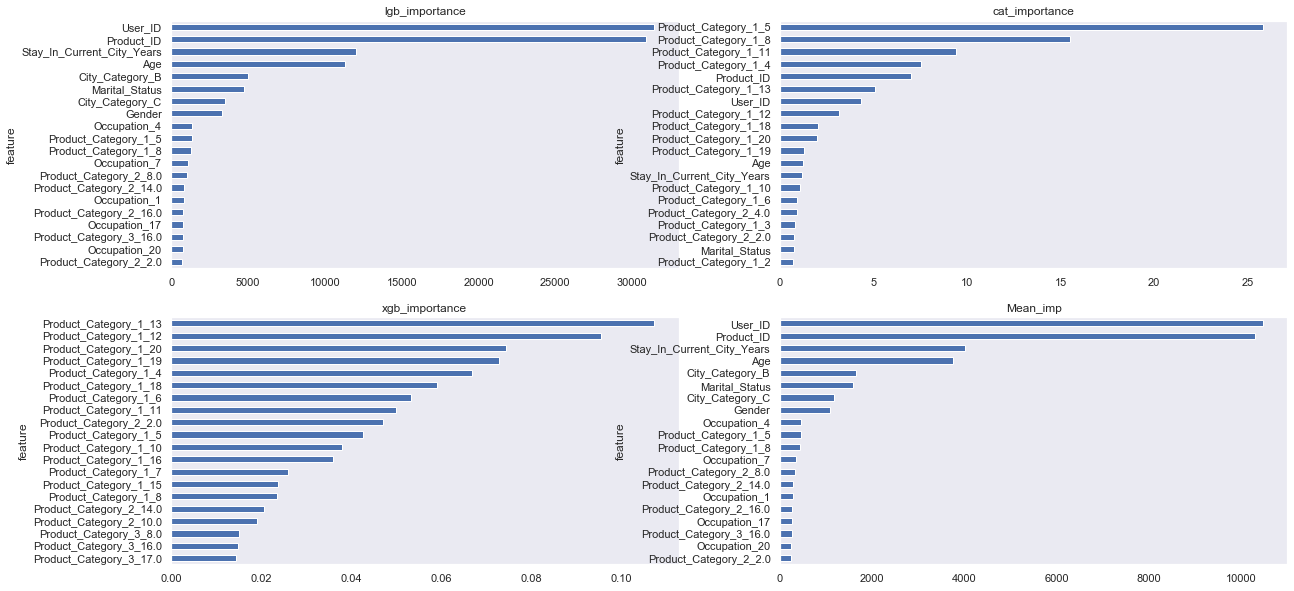

In [30]:
f, ax = plt.subplots(2, 2, figsize = (20,10))
axx = ax.flatten()

for index, col in enumerate(col_ls):
    col.plot(kind = 'barh', ax = axx[index])
    axx[index].set_title(feature_imp.columns[index+1])

---
# Feature Engineering


In [329]:
# MODELS


params = {'random_state' : 1999, 'colsample_bytree' : 0.7, 'max_depth': 18, 'n_estimators': 300, 'learning_rate': 0.2, 'num_leaves': 1779, 'min_child_samples': 181, 'reg_alpha': 3, 'reg_lambda': 1}
lgb = LGBMRegressor(**params)


params = {'random_state' : 1999, 'max_depth': 7, 'n_estimators': 496, 'learning_rate': 0.5604363463067941, 'colsample_bytree': 0.3320641259206344, 'reg_alpha': 7, 'reg_lambda': 6}
xgb = XGBRegressor(**params)


params = {'random_state' : 1999, 'max_depth': 11, 'n_estimators': 768, 'learning_rate': 0.19202927929990196, 'rsm': 0.9645427036490625, 'reg_lambda': 6}
cat = CatBoostRegressor(verbose=False, **params)


In [330]:
def helper(df, column_list):
    for col in column_list:
        train_proc[col] = df[: train.shape[0]][col].reset_index(drop = True)
        test_proc[col] = df[train_proc.shape[0]:][col].reset_index(drop = True)
        features = [col for col in train_proc.columns if col not in [target]]
    return features

### 1. Features from EDA

In [331]:
df = pd.concat([train, test], axis = 0).reset_index(drop=True)

In [332]:
# Does user belongs to working class or not
df['is_working'] = df['Age'].apply(lambda x: 1 if (x!='0-17' and x!='55+' and x!='51-55' and x!='46-50') else 0)

In [333]:
# Does particular product_cat_1 is popular or not
df['is_popular'] = df['Product_Category_1'].apply(lambda x: 1 if x in [1,5,8] else 0)

In [334]:
col_ls = ['is_working', 'is_popular', ]

features = helper(df, col_ls)

In [309]:
fe_lgb_base_oofs, fe_lgb_base_preds = boosting_cross_val(lgb, train_proc, test_proc, features, 'lgb')

sample_sub['Purchase'] = fe_lgb_base_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Feature_Engineering.csv", index = False)


=========================Fold1============================


ValueError: could not convert string to float: 'A'

In [335]:
female_prod_ls = list(set(df[ df['Gender'] == 'F']['Product_ID'].to_list()))
male_prod_ls = list(set(df[ df['Gender'] == 'M']['Product_ID'].to_list()))

female_products = list(np.setdiff1d(female_prod_ls, male_prod_ls))
male_products = list(np.setdiff1d( male_prod_ls, female_prod_ls))

# Does only females are buying particluar product_id
df['is_female_product'] = df['Product_ID'].apply(lambda x: 1 if x in female_products else 0)

# Does only males are buying particluar product_id
df['is_male_product'] = df['Product_ID'].apply(lambda x: 1 if x in male_products else 0)

In [336]:
col_ls = ['is_female_product', 'is_male_product']

features = helper(df, col_ls)

In [68]:
fe_lgb_base_oofs, fe_lgb_base_preds = boosting_cross_val(lgb, train_proc, test_proc, features, 'lgb')


=========================Fold1============================

 RMSE score for Validation set is : 2527.5967491567926

=========================Fold2============================

 RMSE score for Validation set is : 2553.998237429995

=========================Fold3============================

 RMSE score for Validation set is : 2555.2751088926425

=========================Fold4============================

 RMSE score for Validation set is : 2549.0897474830795

=========================Fold5============================

 RMSE score for Validation set is : 2543.7780137319023


RMSE score for oofs is 2545.967332304913


In [69]:
sample_sub['Purchase'] = fe_lgb_base_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Feature_Engineering.csv", index = False)

---
### 2. Grouping Features

In [337]:
# Number of unique product id's per user
df['Users_unique_products'] = df.groupby('User_ID')['Product_ID'].transform('nunique')

# Number of unique users per product_id
df['Products_unique_users'] = df.groupby('Product_ID')['User_ID'].transform('nunique')

# Number of unique products per city
df['Citys_unique_products'] = df.groupby('City_Category')['Product_ID'].transform('nunique')

# Number of unique products per Age_group
df['Age_unique_products'] = df.groupby('Age')['Product_ID'].transform('nunique')

# Number of unique Users per Age_group
df['Age_unique_users'] = df.groupby('Age')['User_ID'].transform('nunique')

# Number of unique Products per Occupation
df['Occupation_unique_products'] = df.groupby('Occupation')['Product_ID'].transform('nunique')

# Number of unique Users per Occupation
df['Occupation_unique_users'] = df.groupby('Occupation')['User_ID'].transform('nunique')

In [338]:
df['Users_Mean_Purchase'] = df.groupby('User_ID')['Purchase'].transform('mean')
df['Users_Median_Purchase'] = df.groupby('User_ID')['Purchase'].transform('median')
df['Products_Mean_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('mean')
df['Products_Median_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('median')

df['Product_Category_1_Mean_Purchase'] = df.groupby('Product_Category_1')['Purchase'].transform('mean')
df['Product_Category_1_Median_Purchase'] = df.groupby('Product_Category_1')['Purchase'].transform('median')

#df['Product_Category_2_Mean_Purchase'] = df.groupby('Product_Category_2')['Purchase'].transform('mean')
#df['Product_Category_2_Median_Purchase'] = df.groupby('Product_Category_2')['Purchase'].transform('median')

#df['Product_Category_3_Mean_Purchase'] = df.groupby('Product_Category_3')['Purchase'].transform('mean')
#df['Product_Category_3_Median_Purchase'] = df.groupby('Product_Category_3')['Purchase'].transform('median')



In [339]:
col_ls = ['Users_unique_products', 'Products_unique_users', 'Citys_unique_products', 'Age_unique_products', 'Age_unique_users',
 'Occupation_unique_products', 'Occupation_unique_users','Users_Mean_Purchase', 'Users_Median_Purchase', 'Products_Mean_Purchase', 'Products_Median_Purchase',
         'Product_Category_1_Mean_Purchase', 'Product_Category_1_Median_Purchase']

features = helper(df, col_ls)

In [227]:
#df['Users_Total_Purchase'] = df.groupby('User_ID')['Purchase'].transform('sum')
#df['Products_Total_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('sum')

#df['Users_Minimum_Purchase'] = df.groupby('User_ID')['Purchase'].transform('min')
#df['Products_Minimum_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('min')

#df['Users_Maximum_Purchase'] = df.groupby('User_ID')['Purchase'].transform('max')
#df['Products_Maximum_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('max')


In [252]:
#col_ls = ['Users_Total_Purchase', 'Products_Total_Purchase', 'Users_Minimum_Purchase', 'Products_Minimum_Purchase', 
#         'Users_Maximum_Purchase', 'Products_Maximum_Purchase']
#
#features = helper(df, col_ls)
#####

KeyError: 'Users_Total_Purchase'

In [340]:
lgb_oofs, lgb_preds = boosting_cross_val(lgb, train_proc, test_proc, features, 'lgb')
sample_sub['Purchase'] = fe_lgb_base_preds
#sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Feature_Engineering.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2426.7083845586367

=========================Fold2============================

 RMSE score for Validation set is : 2429.2519740200482

=========================Fold3============================

 RMSE score for Validation set is : 2432.988120566455

=========================Fold4============================

 RMSE score for Validation set is : 2431.067071592002

=========================Fold5============================

 RMSE score for Validation set is : 2443.1317868211086


RMSE score for oofs is 2432.6360011449947


In [264]:
xgb_oofs, xgb_preds = boosting_cross_val(xgb, train_proc, test_proc, features, 'xgb')
sample_sub['Purchase'] = fe_lgb_base_preds
#sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Feature_Engineering.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2470.334979348195

=========================Fold2============================

 RMSE score for Validation set is : 2459.410596495955

=========================Fold3============================

 RMSE score for Validation set is : 2456.27582758716

=========================Fold4============================

 RMSE score for Validation set is : 2460.995800306936

=========================Fold5============================

 RMSE score for Validation set is : 2469.747297289554


RMSE score for oofs is 2463.3594213795013


In [265]:
cat_oofs, cat_preds = boosting_cross_val(cat, train_proc, test_proc, features, 'cat')
sample_sub['Purchase'] = fe_lgb_base_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Feature_Engineering.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2418.4192981031592

=========================Fold2============================

 RMSE score for Validation set is : 2427.892093068631

=========================Fold3============================

 RMSE score for Validation set is : 2422.385836851996

=========================Fold4============================

 RMSE score for Validation set is : 2421.94402800197

=========================Fold5============================

 RMSE score for Validation set is : 2430.1332491118806


RMSE score for oofs is 2424.15863246384


---
# Ensembling

In [266]:
train_new = train_proc[[target, 'User_ID']].copy()
test_new = test_proc[[target, 'User_ID']].copy()

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cat_oofs
test_new['cb'] = cat_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

ens_features = [c for c in train_new.columns if c not in [target, 'User_ID']]

In [281]:
from sklearn.linear_model import Lasso
clf = Lasso()

ens_oofs, ens_preds = cross_val(clf, train_new, test_new, ens_features)


=========================Fold1============================

 RMSE score for Validation set is : 2400.316089930955

=========================Fold2============================

 RMSE score for Validation set is : 2411.0734870531796

=========================Fold3============================

 RMSE score for Validation set is : 2414.8017669750066

=========================Fold4============================

 RMSE score for Validation set is : 2412.3873639468816

=========================Fold5============================

 RMSE score for Validation set is : 2409.544369705774


RMSE score for oofs is 2409.629723070253


In [282]:
sample_sub['Purchase'] = ens_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Ensemble.csv", index = False)

### Got RMSE of 2439.73 on Leaderboard

# Hyperparameter Tuning For Current Data (With Created Features)

In [348]:
uint8_cols = ['is_working', 'is_popular', 'is_female_product', 'is_male_product']

int16_cols = ['Users_unique_products', 'Products_unique_users', 'Citys_unique_products', 'Age_unique_products', 'Age_unique_users',
             'Occupation_unique_products', 'Occupation_unique_users', 'Users_Mean_Purchase', 'Users_Median_Purchase', 'Products_Mean_Purchase',
             'Products_Median_Purchase', 'Product_Category_1_Mean_Purchase', 'Product_Category_1_Median_Purchase']

In [432]:
test_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 97 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   User_ID                             233599 non-null  int16
 1   Product_ID                          233599 non-null  int16
 2   Gender                              233599 non-null  uint8
 3   Age                                 233599 non-null  uint8
 4   Stay_In_Current_City_Years          233599 non-null  uint8
 5   Marital_Status                      233599 non-null  uint8
 6   Purchase                            233599 non-null  int32
 7   Occupation_1                        233599 non-null  uint8
 8   Occupation_2                        233599 non-null  uint8
 9   Occupation_3                        233599 non-null  uint8
 10  Occupation_4                        233599 non-null  uint8
 11  Occupation_5                        233599 non-null 

##### Imputing Products_Mean_Purchase and Products_Median_Purchase by Product_Category_1_Mean_Purchase and Product_Category_1_Median_Purchase respectively

In [373]:
test_proc.loc[ test_proc['Products_Mean_Purchase'].isna(), 'Products_Mean_Purchase'] = test_proc[ test_proc['Products_Mean_Purchase'].isna()]['Product_Category_1_Mean_Purchase'].apply(lambda x: x)

In [376]:
test_proc.loc[ test_proc['Products_Median_Purchase'].isna(), 'Products_Median_Purchase'] = test_proc[ test_proc['Products_Median_Purchase'].isna()]['Product_Category_1_Median_Purchase'].apply(lambda x: x)

In [349]:
train_proc[uint8_cols] = train_proc[uint8_cols].astype('uint8')
test_proc[uint8_cols] = test_proc[uint8_cols].astype('uint8')

In [431]:
train_proc[int16_cols] = train_proc[int16_cols].astype('int16')
test_proc[int16_cols] = test_proc[int16_cols].astype('int16')

---
# Spliting into train, val and test

In [387]:
traget = 'Purchase'

features = [col for col in train_proc.columns if col not in [target]]

In [389]:
trn, val = train_test_split(train_proc, test_size = 0.2, random_state = 1999)

##### Input for model
X_trn, X_val = trn[features], val[features]

##### Target column
y_trn, y_val = trn[target], val[target]

##### Features for test data that we will be predicting
X_test = test_proc[features]

### 1. LGBM 

In [398]:
%%time
lgb = LGBMRegressor(random_state=1999)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')


RMSE score is: 2473.1571412379185
Wall time: 3.13 s


In [399]:
test_preds = lgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)

In [405]:
lgb_fe_oofs, lgb_fe_preds = boosting_cross_val(lgb, train_proc, test_proc, features)
sample_sub['Purchase'] = lgb_fe_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2430.4426892934575

=========================Fold2============================

 RMSE score for Validation set is : 2434.567303379707

=========================Fold3============================

 RMSE score for Validation set is : 2432.1161836446245

=========================Fold4============================

 RMSE score for Validation set is : 2431.923027071152

=========================Fold5============================

 RMSE score for Validation set is : 2435.5846905381436


RMSE score for oofs is 2432.927498820389


## Hyperparameter Tuning

In [404]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves,
        colsample_bytree = colsample_bytree,
        min_child_samples=min_child_samples,
        random_state=1999
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMRegressor(**lgb_params)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-05 21:38:24,156] A new study created in memory with name: no-name-7bf9dc2f-9775-43ba-a26c-c360495eaf70
[I 2020-10-05 21:38:29,043] Trial 0 finished with value: 2546.356198744948 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7436704297351775, 'num_leaves': 4933, 'colsample_bytree': 0.7863564940982054, 'min_child_samples': 106, 'reg_alpha': 10, 'reg_lambda': 4}. Best is trial 0 with value: 2546.356198744948.
[I 2020-10-05 21:39:12,863] Trial 1 finished with value: 2766.5291887612984 and parameters: {'max_depth': 23, 'n_estimators': 243, 'learning_rate': 0.49382849013642327, 'num_leaves': 3470, 'colsample_bytree': 0.40675321506062223, 'min_child_samples': 42, 'reg_alpha': 8, 'reg_lambda': 9}. Best is trial 0 with value: 2546.356198744948.
[I 2020-10-05 21:39:29,198] Trial 2 finished with value: 2709.01165195194 and parameters: {'max_depth': 19, 'n_estimators': 166, 'learning_rate': 0.8524708871836397, 'num_leaves': 2165, 'colsample_bytree': 0.39459323

Optimized LightGBM roc_auc_score 2428.5758667848954


In [406]:
%%time
params = {'max_depth': 8, 'n_estimators': 427, 'learning_rate': 0.11399224633135674,
 'num_leaves': 4944, 'colsample_bytree': 0.2481550490857895,
          'min_child_samples': 105, 'reg_alpha': 1, 'reg_lambda': 10}

lgb = LGBMRegressor(random_state=1999,**params)
lgb.fit(X_trn, y_trn)
preds = lgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

RMSE score is: 2429.327526343336
Wall time: 11.4 s


In [407]:
test_preds = lgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)

In [437]:
%%time
lgb_fe_oofs, lgb_fe_preds = boosting_cross_val(lgb, train_proc, test_proc, features, 'lgb')
sample_sub['Purchase'] = lgb_fe_preds
#sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2430.3029036885378

=========================Fold2============================

 RMSE score for Validation set is : 2434.804446720686

=========================Fold3============================

 RMSE score for Validation set is : 2433.127443834257

=========================Fold4============================

 RMSE score for Validation set is : 2433.4409782724174

=========================Fold5============================

 RMSE score for Validation set is : 2432.111369859339


RMSE score for oofs is 2432.757890292266
Wall time: 2min 7s


---
### 2. XGBoost

In [412]:
%%time
xgb = XGBRegressor(random_state=1999)
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')


RMSE score is: 2452.6074975634638
Wall time: 46.3 s


In [413]:
test_preds = xgb.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)

In [416]:
%%time
xgb_fe_oofs, xgb_fe_preds = boosting_cross_val(xgb, train_proc, test_proc, features, 'lgb')
sample_sub['Purchase'] = xgb_fe_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2453.4985618703367

=========================Fold2============================

 RMSE score for Validation set is : 2467.1161262392257

=========================Fold3============================

 RMSE score for Validation set is : 2449.6082197808055

=========================Fold4============================

 RMSE score for Validation set is : 2461.641050936145

=========================Fold5============================

 RMSE score for Validation set is : 2453.6558123656096


RMSE score for oofs is 2457.112169392068
Wall time: 4min 38s


In [418]:
%%time
xgb_fe_oofs, xgb_fe_preds = cross_val(xgb, train_proc, test_proc, features,)
sample_sub['Purchase'] = xgb_fe_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)


=========================Fold1============================

 RMSE score for Validation set is : 2455.6972880358285

=========================Fold2============================

 RMSE score for Validation set is : 2449.610112441388

=========================Fold3============================

 RMSE score for Validation set is : 2456.5976861840086

=========================Fold4============================

 RMSE score for Validation set is : 2454.0954959498913

=========================Fold5============================

 RMSE score for Validation set is : 2461.373804582692


RMSE score for oofs is 2455.4778179618393
Wall time: 4min 20s


#### Hyperparameter Tuning

In [439]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = XGBRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        colsample_bytree = colsample_bytree,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=1999,
        n_jobs = -1
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

xgb_params = study.best_params
xgb_params['random_state'] = 0
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
print('Optimized XGBR RMSE', np.sqrt(mean_squared_error(y_val, preds)))

[I 2020-10-05 23:21:25,384] A new study created in memory with name: no-name-109af6e5-4a61-4b2c-8653-ce3e274810f3
[W 2020-10-05 23:21:45,018] Trial 0 failed because of the following error: MemoryError((440054, 96), dtype('float64'))
Traceback (most recent call last):
  File "C:\Users\sunil\anaconda3\lib\site-packages\optuna\study.py", line 778, in _run_trial
    result = func(trial)
  File "<ipython-input-439-f6438b1b572a>", line 28, in objective
    model.fit(X_trn, y_trn)
  File "C:\Users\sunil\anaconda3\lib\site-packages\xgboost\sklearn.py", line 504, in fit
    nthread=self.n_jobs)
  File "C:\Users\sunil\anaconda3\lib\site-packages\xgboost\core.py", line 520, in __init__
    data, feature_names, feature_types
  File "C:\Users\sunil\anaconda3\lib\site-packages\xgboost\core.py", line 420, in _convert_dataframes
    meta_type)
  File "C:\Users\sunil\anaconda3\lib\site-packages\xgboost\core.py", line 320, in _maybe_pandas_data
    data = data.values.astype(dtype)
MemoryError: Unable to

MemoryError: Unable to allocate 322. MiB for an array with shape (440054, 96) and data type float64

In [ ]:
xgb

In [ ]:
%%time

xgb = xgb
xgb.fit(X_trn, y_trn)
preds = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

In [ ]:
# Cross val

%%time
xgb_fe_oofs, xgb_fe_preds = boosting_cross_val(xgb, train_proc, test_proc, features, 'xgb')
sample_sub['Purchase'] = xgb_fe_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\XGB_FE_Boosting.csv", index = False)

---
### Catboost

In [ ]:
num_cols = ['Users_unique_products', 'Products_unique_users', 'Citys_unique_products', 'Age_unique_products', 'Age_unique_users',
             'Occupation_unique_products', 'Occupation_unique_users', 'Users_Mean_Purchase', 'Users_Median_Purchase', 'Products_Mean_Purchase',
             'Products_Median_Purchase', 'Product_Category_1_Mean_Purchase', 'Product_Category_1_Median_Purchase']

cat_cols = [col for col in train_proc.columns if col not in [num_cols, target]]

In [ ]:
%%time
cat = CatBoostRegressor(cat_features=cat_cols)
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

In [ ]:
test_preds = cat.predict(X_test)

sample_sub['Purchase'] = test_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\FE_Boosting.csv", index = False)

#### Hyperparameter Tuning

In [ ]:
import optuna
from optuna.samplers import TPESampler

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 1, 16)
    n_estimators = trial.suggest_int("n_estimators", 500, 1500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    rsm = trial.suggest_uniform('rsm', 0.1, 0.99)
    #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = CatBoostRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        rsm = rsm,
        #num_leaves=num_leaves, 
        #min_child_samples=min_child_samples,
        random_state=0,
        cat_features=cat_cols,
        verbose = False
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_trn, y_trn)
    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,preds))
    return score

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

cat_params = study.best_params
cat_params['random_state'] = 0
cat = CatBoostRegressor(**cat_params, verbose = False)
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
print('Optimized Catboost RMSE', np.sqrt(mean_squared_error(y_val, preds)))

In [ ]:
cat

In [ ]:
%%time

cat = cat
cat.fit(X_trn, y_trn)
preds = cat.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE score is: {rmse}')

In [ ]:
# Cross val

%%time
cat_fe_oofs, cat_fe_preds = boosting_cross_val(cat, train_proc, test_proc, features, 'cat')
sample_sub['Purchase'] = cat_fe_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\CAT_FE_Boosting.csv", index = False)

---
# Ensembling

In [ ]:
train_new = train_proc[[target, 'User_ID']].copy()
test_new = test_proc[[target, 'User_ID']].copy()

train_new['lgb'] = lgb_fe_oofs
test_new['lgb'] = lgb_fe_preds

train_new['cb'] = cat_fe_oofs
test_new['cb'] = cat_fe_preds

train_new['xgb'] = xgb_fe_oofs
test_new['xgb'] = xgb_fe_preds

ens_features = [c for c in train_new.columns if c not in [target, 'User_ID']]

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

ens_oofs, ens_preds = cross_val(clf, train_new, test_new, ens_features)

In [ ]:
sample_sub['Purchase'] = ens_preds
sample_sub.to_csv(r"D:\Data Science\Projects\Analytics vidya\Black Friday Sales Prediction\Ensemble.csv", index = False)